In [1]:
# Import useful packages
import numpy as np # Arrays and stuff
import matplotlib.pyplot as plt # Plotting
from matplotlib import cm
from numba import njit # Pre-compilation for better performance
from scipy.integrate import solve_ivp

In [458]:
@njit
def lattice_gillespie(T, n_sites, d0, l, n_skip=0):
    # T: timespan to consider
    # n_sites: lattice size
    # d0: initial proportion of infected individuals
    # gamma: parameters of our reaction
    # n_skip: how many steps to skip between saving the values
    
    # healthy -> 0; infected -> 1
    
    n0 = int(n_sites*d0) # Initial number of infected individuals, according to lattice size and initial infected proportion
    
    d0 = n0/n_sites
    
    lat = np.zeros(n_sites) # Create lattice with only healthy individual
    lat[np.random.choice(n_sites, n0)] = 1. # Sort sites to turn into infected, according to given initial infected proportion
    
    t_dat = [0.] # Array to store time values
    d_dat = [d0] # Array to store density of infected individuals
    s_dat = [(np.sum(np.abs(np.diff(lat)))+np.abs(lat[0]-lat[-1]))/n_sites] # Array to store density of healthy/infected interfaces
    
    t = 0 # Variable to store time
    n = n0 # Variable to store number of particles
    
    skip_counter = 1 # Start counter to know when to save value
    
    rates = np.zeros(n_sites) # Array to store transition rates of each site
    
    while t < T:
        for i in range(n_sites):
            if lat[i] == 0:
                rates[i] = l/2*(lat[(i-1)%n]+lat[(i+1)%n])
            else:
                rates[i] = 1
        
        rtot = np.sum(rates) # Total transition rate
        
        weights = rates/rtot # Weight of transition of each site
        w_cum_sum = np.cumsum(weights) # Array with cumulative sum of weights, to chose which site to go under transition
        
        t += np.random.exponential(1/rtot) # Update time according to total transition rate
        
        transition_idx = np.searchsorted(w_cum_sum, np.random.random()) # Choose lattice site to go under transition
        
        # Realize chosen transition
        if lat[transition_idx] == 0:
            lat[transition_idx] = 1.
        else:
            lat[transition_idx] = 0.
        
        # Check if reached 0 infected density
        if np.sum(lat) == 0:
            if d_dat[-1] != 0:
                t_dat.append(t)
                d_dat.append(0)
                s_dat.append(0)
            break
        
        # If skipped enough iterations, save data
        if skip_counter == n_skip+1:
            t_dat.append(t)
            d_dat.append(np.sum(lat)/n_sites)
            s_dat.append((np.sum(np.abs(np.diff(lat)))+np.abs(lat[0]-lat[-1]))/n_sites)
            skip_counter = 0
            
        skip_counter += 1 # Count iteration
    
    return np.array(t_dat), np.array(d_dat), np.array(s_dat)

In [459]:
# Mean field approximation
def mean_field(t, d, l):
    return (l-1)*d-l*d**2

# Gaussian approximation
def gauss_approx(t, y, l):
    d, s = y
    
    return [l*s-d,
            2*d-4*s-2*l*s**2/(1-d)]

Reached 0 infected density!


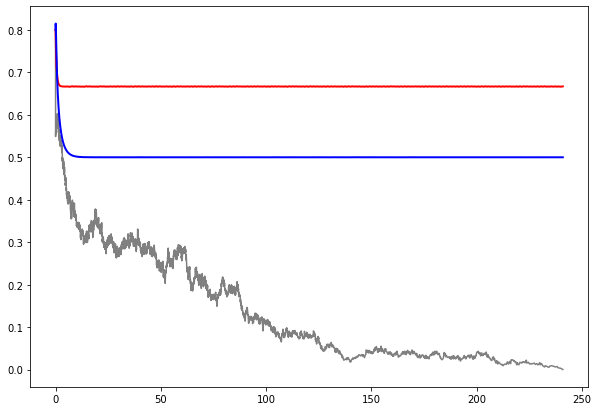

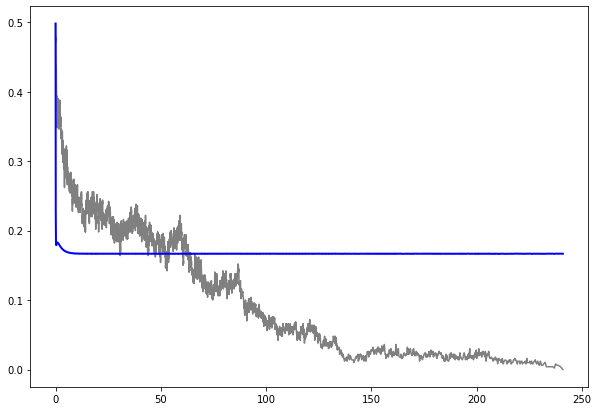

In [457]:
T = 1000
n_sites = 1000
d0 = 0.8
l = 3

t, d, s = lattice_gillespie(T, n_sites, d0, l, 10)
if d[-1] == 0:
    print("Reached 0 infected density!")
mf_d = solve_ivp(mean_field, [t[0], t[-1]], [d0], t_eval=t, args=[l]).y[0]
ga_d, ga_s = solve_ivp(gauss_approx, [t[0], t[-1]], y0=[d0, s[0]], t_eval=t, args=[l]).y

plt.figure(figsize=(10, 7))
plt.plot(t, d, c="gray")
plt.plot(t, mf_d, c="r", lw=2)
plt.plot(t, ga_d, c="b", lw=2)
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(t, s, c="gray")
plt.plot(t, ga_s, c="b", lw=2)
plt.show()